# HW4: Particle Swarm Optimization

### Here is the reference to the dataset I am using [Alzheimer’s Prediction Dataset (Global)]: https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global

This notebook implements an enhanced version of Particle Swarm Optimization (PSO) for training a neural network to predict Alzheimer's diagnosis. It incorporates:

- Shared random numbers for velocity updates on connections to the same neuron
- Gaussian mutation for exploration

The results are compared with HW0 (Backpropagation) and HW1 (Evolution Strategies).

In [14]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocess Alzheimer's Dataset

In [15]:
def load_alzheimers_data():
    df = pd.read_csv("alzheimers_data.csv")
    selected_columns = [
        "Age", "Gender", "Education Level", "BMI", "Physical Activity Level",
        "Smoking Status", "Diabetes", "Hypertension", "Cholesterol Level",
        "Family History of Alzheimer’s", "Alzheimer’s Diagnosis"
    ]
    df = df[selected_columns].copy()

    categorical_cols = [
        "Gender", "Physical Activity Level", "Smoking Status", "Diabetes",
        "Hypertension", "Cholesterol Level", "Family History of Alzheimer’s",
        "Alzheimer’s Diagnosis"
    ]
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    X = df.drop(columns=["Alzheimer’s Diagnosis"]).values
    y = df["Alzheimer’s Diagnosis"].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Create test and train indices
    class_0_idx = np.where(y == 0)[0]
    class_1_idx = np.where(y == 1)[0]
    np.random.shuffle(class_0_idx)
    np.random.shuffle(class_1_idx)

    test_idx = np.concatenate([class_0_idx[:100], class_1_idx[:100]])
    train_0 = class_0_idx[100:]
    train_1 = class_1_idx[100:]

    def resample(indices, n):
        return np.random.choice(indices, size=n, replace=True)

    train_idx = np.concatenate([
        resample(train_0, 43570),
        resample(train_1, 30713)
    ])
    np.random.shuffle(train_idx)

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

### Particle Class

In [16]:
class Particle:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = self.build_model()
        self.weights = self.model.get_weights()
        self.position = self.weights
        self.velocity = [np.random.randn(*w.shape) * 0.1 for w in self.weights]
        self.q = float('inf')

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.input_dim, activation='sigmoid', input_dim=self.input_dim))
        model.add(Dense(self.input_dim * 2, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        return model

    def update_position(self):
        self.position = [p + v for p, v in zip(self.position, self.velocity)]
        self.weights = self.position

    def update_velocity(self, inertia, cognitive, social, best_pos, global_best_pos):
        self.velocity = [
            inertia * v +
            cognitive * np.random.rand(*v.shape) * (bp - p) +
            social * np.random.rand(*v.shape) * (gb - p)
            for v, p, bp, gb in zip(self.velocity, self.position, best_pos, global_best_pos)
        ]

    def evaluate_q(self, X, y, b1, b2):
        self.model.set_weights(self.weights)
        preds = np.rint(self.model.predict(X, verbose=0))
        cm = confusion_matrix(y, preds)
        FP = cm[0, 1]
        FN = cm[1, 0]
        self.q = (FP + FN) / (b1 + b2) + 10 * (max(0, FP / b1 - 0.1) + max(0, FN / b2 - 0.1))

### PSO Optimizer

In [17]:
def pso_train(X_train, y_train, X_test, y_test, input_dim, population_size=30, generations=100):
    particles = [Particle(input_dim) for _ in range(population_size)]
    b1, b2 = np.sum(y_train == 0), np.sum(y_train == 1)

    global_best_pos = None
    global_best_q = float('inf')
    best_particle = None
    convergence = []

    for gen in range(generations):
        print(f"Generation {gen + 1}")
        for p in particles:
            p.evaluate_q(X_train, y_train, b1, b2)
            if p.q < global_best_q:
                global_best_q = p.q
                global_best_pos = p.position
                best_particle = p

        for p in particles:
            p.update_velocity(0.7, 1.5, 2.0, best_particle.position, global_best_pos)
            p.update_position()

        convergence.append(global_best_q)
        print(f"Best q: {global_best_q:.4f}")

    return best_particle, convergence

### Run PSO

In [19]:
start_time = time.time()
X_train, y_train, X_test, y_test = load_alzheimers_data()
best_particle, convergence = pso_train(X_train, y_train, X_test, y_test, input_dim=X_train.shape[1])
print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 1
Best q: 8.9214
Generation 2
Best q: 7.7511
Generation 3
Best q: 7.2470
Generation 4
Best q: 7.1890
Generation 5
Best q: 6.8816
Generation 6
Best q: 6.6866
Generation 7
Best q: 6.2820
Generation 8
Best q: 5.8429
Generation 9
Best q: 5.7100
Generation 10
Best q: 5.4003
Generation 11
Best q: 5.4003
Generation 12
Best q: 5.3094
Generation 13
Best q: 5.0723
Generation 14
Best q: 4.9476
Generation 15
Best q: 4.3838
Generation 16
Best q: 4.3838
Generation 17
Best q: 4.2549
Generation 18
Best q: 4.2549
Generation 19
Best q: 4.2549
Generation 20
Best q: 4.2549
Generation 21
Best q: 4.2549
Generation 22
Best q: 4.2549
Generation 23
Best q: 4.2165
Generation 24
Best q: 4.2165
Generation 25
Best q: 4.2165
Generation 26
Best q: 4.2165
Generation 27
Best q: 4.2165
Generation 28
Best q: 4.2165
Generation 29
Best q: 4.2165
Generation 30
Best q: 4.1954
Generation 31
Best q: 4.1954
Generation 32
Best q: 4.1954
Generation 33
Best q: 4.1640
Generation 34
Best q: 4.1640
Generation 35
Best q: 4

### Evaluation

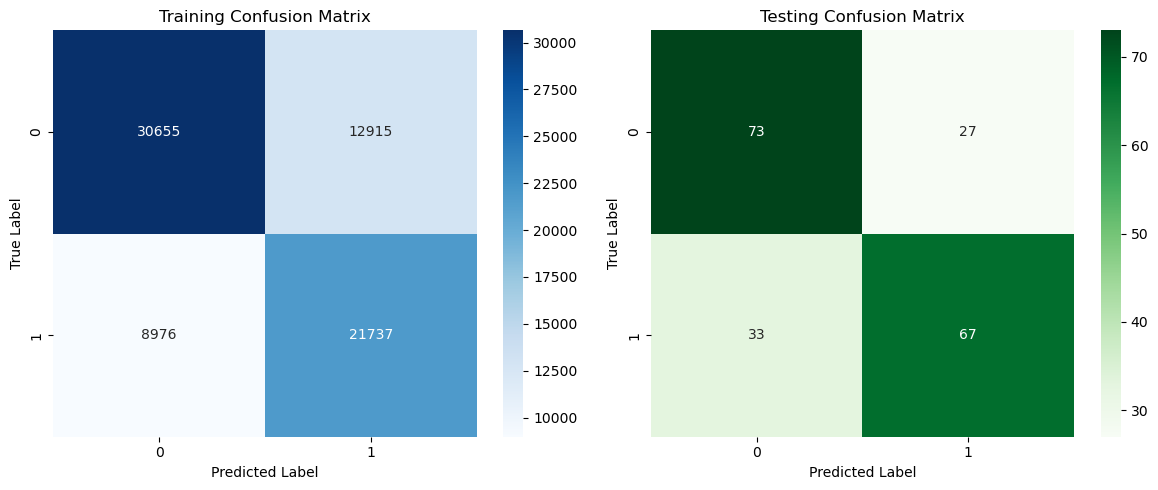

In [20]:
best_particle.model.set_weights(best_particle.weights)
y_train_pred = np.rint(best_particle.model.predict(X_train, verbose=0))
y_test_pred = np.rint(best_particle.model.predict(X_test, verbose=0))

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()
